# Notebook to validate correct ReSNet implementation

Loading local weights from /Users/dariusgiannoli/Desktop/Recognition-BenchMark/models/resnet18.pth
Loaded trained head from /Users/dariusgiannoli/Desktop/Recognition-BenchMark/models/resnet18_head.pkl
✅ ResNet Detector Loaded.
🖼️ Loaded Image: (1080, 1920, 3)

🚀 Starting Brute Force Scan...
   - Window: 224x224
   - Stride: 50px

📊 BENCHMARK RESULTS
Total Windows Scanned: 612
Total Time Taken:      3.1111 seconds
Time Per Window:       5.08 ms
Detections Found:      11


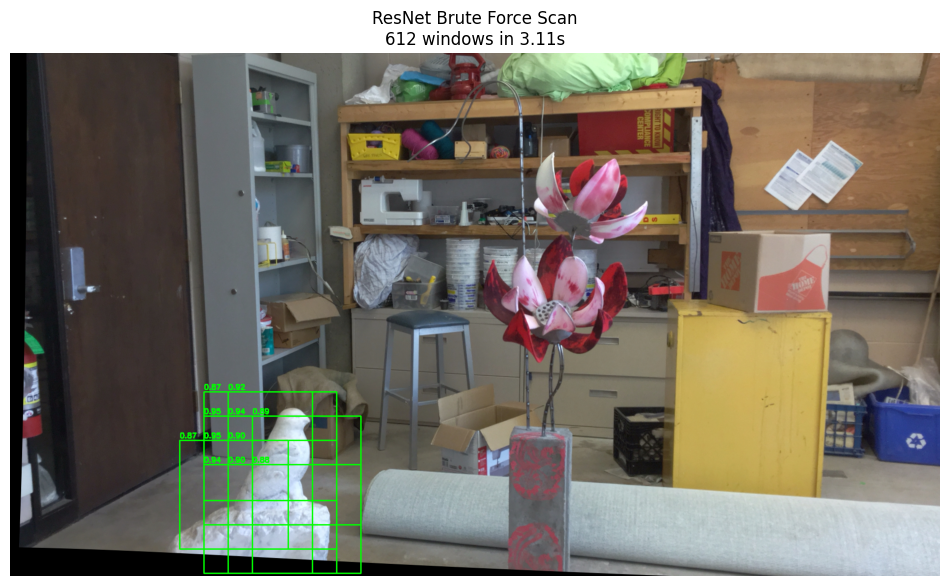

In [3]:
import sys
import os
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# 1. Setup Project Path
# We use .parent because the notebook is inside 'notebooks/'
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.append(str(PROJECT_ROOT))

from src.detectors.resnet import ResNetDetector
from src.config import PROJECT_ROOT

# 2. Initialize the ResNet Brain
# This loads your 'resnet18.pth' backbone + 'resnet18_head.pkl'
detector = ResNetDetector()
print("✅ ResNet Detector Loaded.")

# 3. Load the Test Image (The big art room)
img_path = PROJECT_ROOT / "data/artroom/im0.png"
img = cv2.imread(str(img_path))

if img is None:
    print(f"❌ Error: Could not load image from {img_path}")
else:
    print(f"🖼️ Loaded Image: {img.shape}")

# ====================================================
# 4. THE BRUTE FORCE SCANNER (Sliding Window)
# ====================================================

def sliding_window(image, step_size, window_size):
    """Generates (x, y, window) for the brute force loop."""
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            yield (x, y, image[y:y + window_size[1], x:x + window_size[0]])

# Settings
window_w, window_h = 224, 224  # ResNet expects 224x224
stride = 50              # Move 50 pixels at a time (Smaller = Slower but more accurate)
confidence_threshold = 0.85    # Only show strong matches

print(f"\n🚀 Starting Brute Force Scan...")
print(f"   - Window: {window_w}x{window_h}")
print(f"   - Stride: {stride}px")

detections = []
total_windows = 0
start_time = time.perf_counter()

# --- THE LOOP ---
for (x, y, window) in sliding_window(img, stride, (window_w, window_h)):
    total_windows += 1
    
    # 1. Classify this specific patch
    label, conf, ms = detector.predict(window)
    
    # 2. If it's a bird with high confidence, save it
    if label == 'bird' and conf > confidence_threshold:
        detections.append((x, y, conf))
        # Optional: Print live hits (can be spammy)
        # print(f"   Found Bird at ({x}, {y}) | Conf: {conf:.2%}")

end_time = time.perf_counter()
total_time = end_time - start_time

# ====================================================
# 5. VISUALIZATION & RESULTS
# ====================================================

# Draw boxes on the image
result_img = img.copy()
for (x, y, conf) in detections:
    # Draw Green Box
    cv2.rectangle(result_img, (x, y), (x + window_w, y + window_h), (0, 255, 0), 2)
    # Draw Label
    cv2.putText(result_img, f"{conf:.2f}", (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Convert to RGB for Matplotlib
result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)

print("\n" + "="*30)
print("📊 BENCHMARK RESULTS")
print("="*30)
print(f"Total Windows Scanned: {total_windows}")
print(f"Total Time Taken:      {total_time:.4f} seconds")
print(f"Time Per Window:       {(total_time/total_windows)*1000:.2f} ms")
print(f"Detections Found:      {len(detections)}")
print("="*30)

# Plot
plt.figure(figsize=(12, 8))
plt.imshow(result_img)
plt.title(f"ResNet Brute Force Scan\n{total_windows} windows in {total_time:.2f}s")
plt.axis('off')
plt.show()